# Analysing the CRA compensation of the Raspberry Pi Camera Module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from extract_raw_image import load_raw_image
import sys
import os
from __future__ import print_function
%matplotlib notebook

In [2]:
data_folder = "./run_3/straight/"

## Load images and plot raw data
There are four images in data_folder, corresponding to red, green, blue, and white illumination.  These are loaded in, using the raw data that's included at the end of the JPEG files (decoded using a hacked version of the ``picamera`` library's ``picamera.array`` module that runs on non-Raspberry Pi computers).  These are split into R,G,B colour planes, but not demosaiced, so each colour plane has a lot of black pixels in it.  For convenience, I then bin each of the images, which removes the black pixels and makes processing much easier.

One non-obvious but very important step is correcting the black level.  The 10-bit readings from each pixel are corrected on-chip for black level, using non-light-sensitive reference pixels.  The digital level corresponding to no light is adjusted to be 64 in the 10-bit readings.  The processing used here throws away the bottom two bits, meaning that the black level (for R and B) is 16.  For green, we end up with a black level of 32, because there are twice as many green pixels, and the binning process means the green values are doubled.  NB this means that the images are signed integers, and may have (slightly) negative values.  The binned images plotted below have been converted to 8-bit integers.  Any negative pixels will appear as bright ones, and I don't see any bright dots.

The images plotted by this cell are what is obtained from the sensor, under red, gree, and blue illumination, after binning and adjusting the black level to zero.  Each column represents an illumination colour (white, red, green, then blue) and each row represents a colour channel in the image.  The final row is the RGB image, extracted from the raw data with minimal additional processing.

<IPython.core.display.Javascript object>


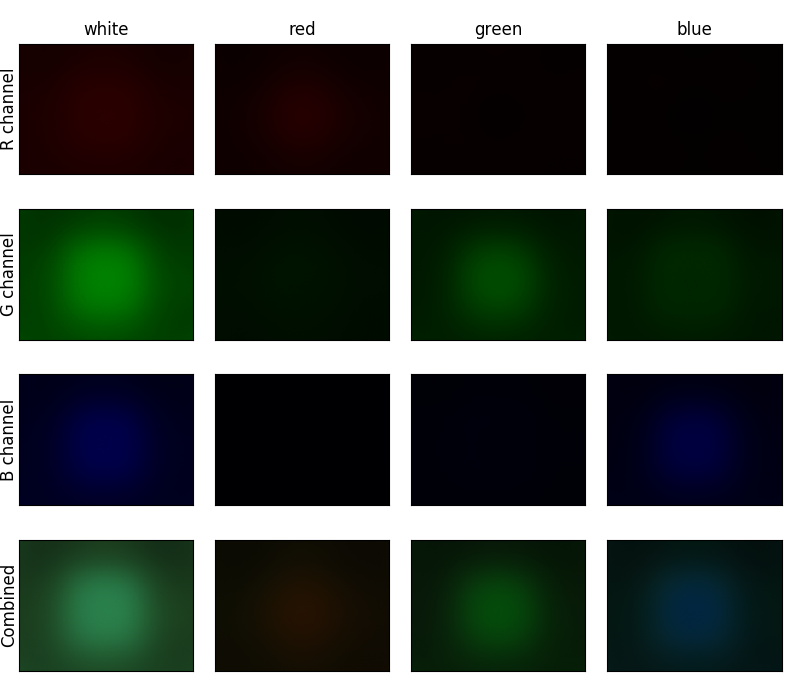

In [75]:
from matplotlib.colors import LinearSegmentedColormap

def bin(image, b=2):
    """Bin bxb squares of an image together"""
    w,h = image.shape[:2]
    new_shape = (w//b, b, h//b, b)
    if len(image.shape) > 2:
        new_shape += image.shape[2:]
    if w % b != 0 or h % b != 0:
        print("Warning: pixels are being dropped from the binned image!")
        image = image[:w - (w%b), :h - (h%b), ...]
    return image.reshape(new_shape).mean(axis=1).mean(axis=2)

illuminations = [(255,255,255), (255,0,0), (0,255,0), (0,0,255)]
binned_images = []

fig, ax = plt.subplots(4, 4, figsize=(8,7))
for i, rgb in enumerate(illuminations):
    pi_bayer_array = load_raw_image(os.path.join(data_folder, "capture_r{}_g{}_b{}.jpg".format(*rgb)))
    image = pi_bayer_array.array - np.array([16,32,16])[np.newaxis,np.newaxis,:] # correct for the zero offset in the raw data
    channels = ["red", "green", "blue"]
    for j, channel in enumerate(channels):
        cm = LinearSegmentedColormap(channel+"map",
                {c: [(0,0,0),(1,1,1)] if c==channel 
                    else [(0,0,0),(0.95,0,1),(1,1,1)] 
                    for c in channels})
        ax[j,i].imshow(bin(image[:,:,j],16), vmin=0, vmax=255, cmap=cm)
    binned_images.append(bin(image, 16))
    image_8bit = binned_images[-1].astype(np.uint8)
    ax[3,i].imshow(image_8bit)
    
for row in ax:
    for axis in row:
        # tidy up the plot (hide axes)
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)

def wrgb_col_titles(axes):
    for topax, title in zip(axes, ["white", "red", "green", "blue"]):
        topax.set_title(title)
def row_titles(axes, titles):
    for ax, title in zip(axes, titles):
        ax.annotate(title, xy=(0, 0.5), xytext=(0, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='left', va='center', rotation="vertical")
        
def imshow_with_section(ax, image, clip=True):
    """Convert an image to 8 bit and display it in the axes.  Overlay sections through the middle.
    
    if clip==True (default) pixels are constrained to 0-255, to avoid overflow.
    """
    if clip:
        clipped_image = image.copy()
        clipped_image[clipped_image<0] = 0
        clipped_image[clipped_image>255] = 255
    else:
        clipped_image = image
    ax.imshow(clipped_image.astype(np.uint8), origin="bottom")
    x = np.arange(image.shape[1])
    h = image.shape[0]
    for i, col in enumerate(["red","green","blue"]):
        ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color=col)
        ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color="dark"+col, dashes=(2,4))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
        
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0], ["R channel", "G channel", "B channel", "Combined"])
plt.tight_layout()

As a quick sanity-check, let's make sure that the black level is OK; if the sensor is behaving itself, we should be able to add up the images under R/G/B illumination, and get something very close to the image taken under white illumination:

<IPython.core.display.Javascript object>


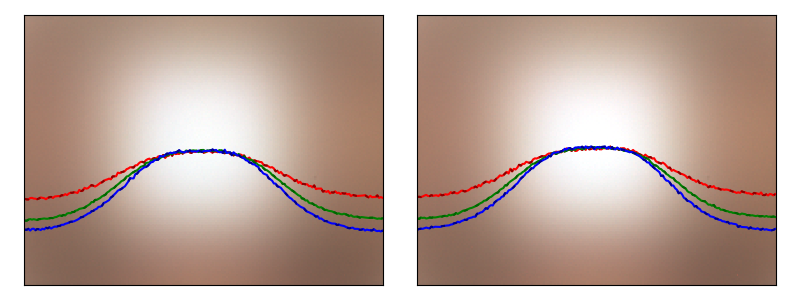

In [76]:
f, ax = plt.subplots(1,2, figsize=(8,3))
norm_centre = 255.0/np.max(np.max(binned_images[0], axis=0), axis=0)[np.newaxis,np.newaxis,:]
imshow_with_section(ax[0], (binned_images[0])*norm_centre)
imshow_with_section(ax[1], np.sum(np.array(binned_images[1:]), axis=0)*norm_centre)
f.tight_layout()

## Next, normalise
The lens shading/flat field correction will divide through by an image that should be uniform, to normalise the response across the sensor.  There are two sensible ways to do this:

* Take a white image, and assume there is no crosstalk
* Take 3 images, each of R,G,B, and use the R,G,B channel from each image to make a composite.  This will tend to be dimmer than the first method.

<IPython.core.display.Javascript object>


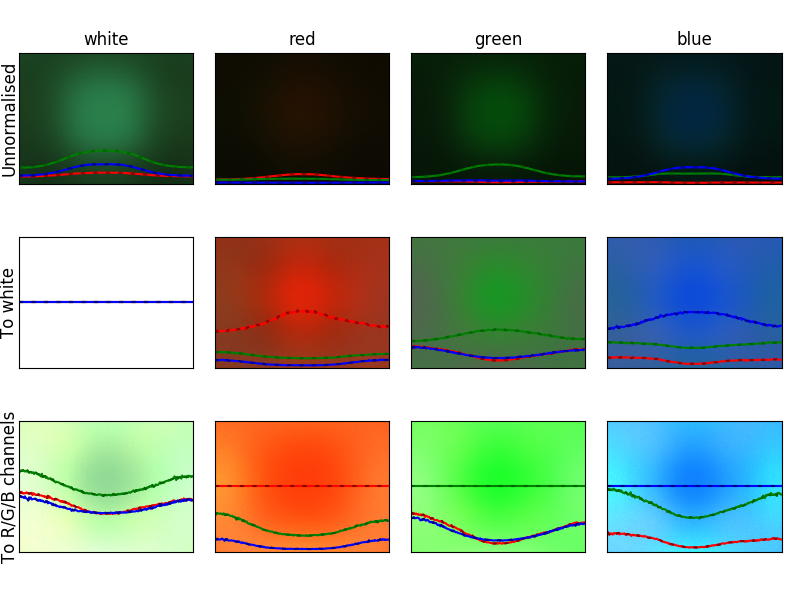

In [77]:
norm_white = 255./binned_images[0]
norm_single = np.zeros_like(norm_white)
for i in range(3):
    norm_single[:,:,i] = 255./binned_images[i+1][:,:,i]

fig, ax = plt.subplots(3, 4, figsize=(8,6))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    imshow_with_section(ax[0,i], image)
    imshow_with_section(ax[1,i], image*norm_white)
    imshow_with_section(ax[2,i], image*norm_single*(0.5 if i==0 else 1.0))
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0],["Unnormalised","To white","To R/G/B channels"])
fig.tight_layout()

After normalising to equalise the intensity of the different channels, we start to see red, green, and blue images for single-colour illumination.  However, crosstalk between the colour channels is clearly much worse at the edges of the images.  We can try to correct for this by using a linear model - what we want is a 3x3 matrix *for each pixel* in our image.  The forward model would just be the R,G,B values obtained for each of R,G,B illumination.  That is quite simple to do:

In [24]:
crosstalk_matrices = np.stack(binned_images[1:], axis=3)/255.0

The indices in this matrix are:
1. y coordinate
2. x coordinate
3. sensor (recorded) colour channel
4. illumination (true) colour channel

What we want to do now is invert each matrix (there are a few of them!) to create a transformation that will recover the colours, assuming crosstalk is only linear (which ought to be a good assumption.  This may take some time!

In [25]:
compensation_matrices = np.empty_like(crosstalk_matrices)
for i in range(crosstalk_matrices.shape[0]):
    for j in range(crosstalk_matrices.shape[1]):
        compensation_matrices[i,j,:,:] = np.linalg.inv(crosstalk_matrices[i,j,:,:])

In this resulting matrix, indices 3 and 4 are swapped, so 3 corresponds to the true colour channel and 4 matches with the recorded colour channel.  Now, for each of our input illuminations, we should be able to recover a nicely corrected image.  I've written out the matrix multiplications as a product and a sum, because that avoids a for loop.  This is mathematically identical to multiplying each RGB pixel value by the 3x3 correction matrix for that pixel.

<IPython.core.display.Javascript object>


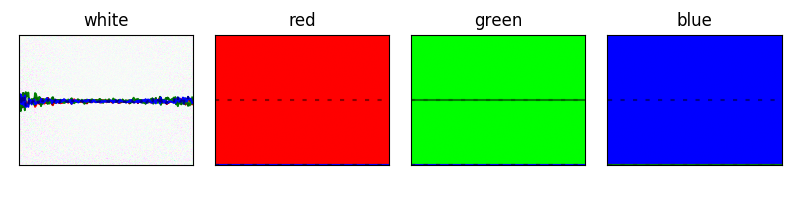

In [78]:
fig, ax = plt.subplots(1, 4, figsize=(8,2))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    output = np.sum(compensation_matrices * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[i], output)
    
wrgb_col_titles(ax)
fig.tight_layout()

<IPython.core.display.Javascript object>


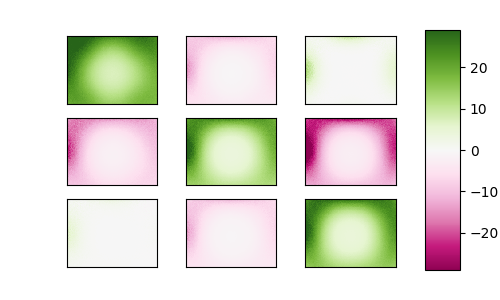

In [102]:
def plot_compensation_matrix(matrix, r=None, clip_range=1):
    """Plot an NxMx3x3 compensation matrix nicely."""
    if r is None:
        r = max(matrix.max(), -matrix.min())
    r *= clip_range
    fig, ax = plt.subplots(3,3, figsize=(5,3))
    for i in range(3):
        for j in range(3):
            implot = ax[i,j].imshow(matrix[:,:,i,j], vmin=-r, vmax=r, cmap="PiYG")
            ax[i,j].xaxis.set_visible(False)
            ax[i,j].yaxis.set_visible(False)
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85,0.1,0.07,0.8])
    fig.colorbar(implot, cax=cax)
    return fig, ax
    
_ = plot_compensation_matrix(compensation_matrices, clip_range=0.7)

My guess is that the white image looks really noisy because the noise in the individual R/G/B images is being cancelled out by the per-pixel compensation matrices.  Perhaps it would be better to smooth those matrices quite agressively, so that camera noise remains camera noise...

<IPython.core.display.Javascript object>


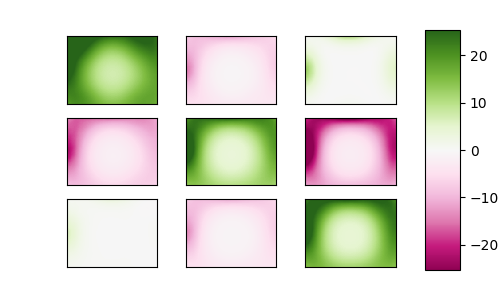

In [103]:
import scipy.ndimage as ndimage
smoothed_compensation = ndimage.gaussian_filter(compensation_matrices, (3,3,0,0), order=0)

_ = plot_compensation_matrix(smoothed_compensation, clip_range=0.7)

That will increase the noise on the colour channel images, and improve the noise on the white image.

This matrix is actually doing two jobs - normalising the brightness, and unmixing the colour channels.  We can separate out these two tasks into one diagonal matrix that normalises the colours, and a second one that unmixes them.  Rather than remove the whole diagonal component, we can divide through by the normalise-to-white image:

<IPython.core.display.Javascript object>


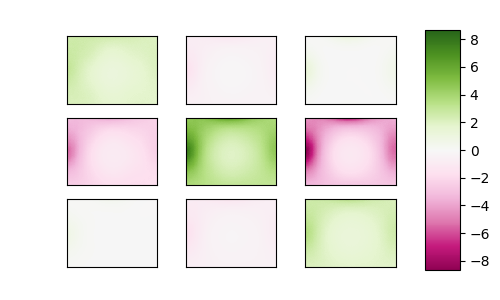

<IPython.core.display.Javascript object>


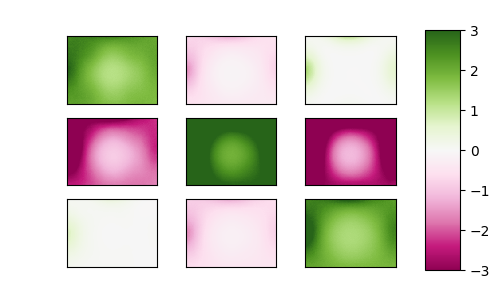

In [108]:
unmixing_matrix = smoothed_compensation / norm_white[:,:,:,np.newaxis]
_ = plot_compensation_matrix(unmixing_matrix)
_ = plot_compensation_matrix(unmixing_matrix, r=3)

For a summary, I've plotted unnormalised, the two possible normalisations (which could be done with a revised lens shading table) and the full correction (which would require post-processing or some other solution that's not in the current pipeline.)

<IPython.core.display.Javascript object>


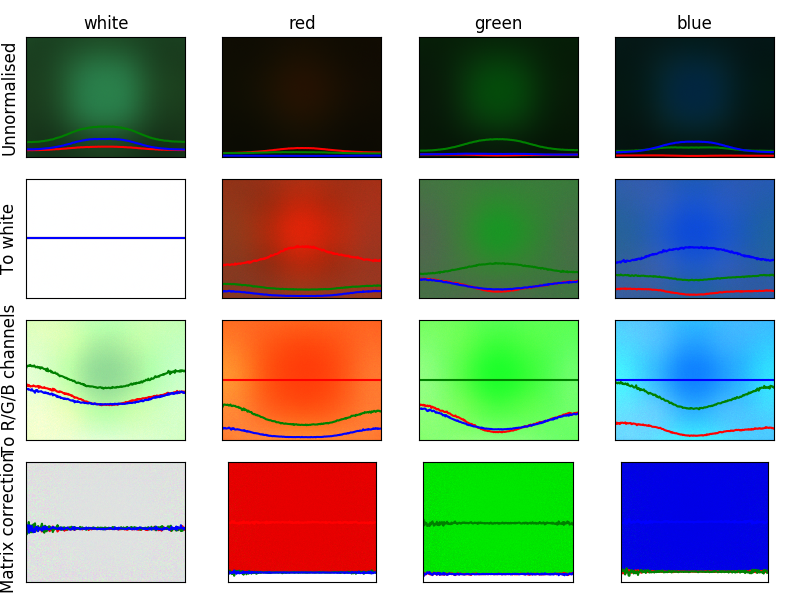

In [37]:
fig, ax = plt.subplots(4, 4, figsize=(8,6))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    imshow_with_section(ax[0,i], image)
    imshow_with_section(ax[1,i], image*norm_white)
    imshow_with_section(ax[2,i], image*norm_single*(0.5 if i==0 else 1.0))
    output = np.sum(smoothed_compensation * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[3,i], output*0.9)
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0],["Unnormalised","To white","To R/G/B channels","Matrix correction"])
fig.tight_layout()

The SNR of the image will go up with the matrix correction - this is visible in the white image in the bottom row.  Of course it's possible to trade off colour fidelity against noise (going from either of the middle rows to the bottom row) but that's just a question of aesthetics.  We can, however, quantify the SNR by making some assumptions:
* There is equal noise on each channel of the image
* The noise on colour channels is independent and identically distributed
For each output colour channel, the *noise* will be the input noise, multiplied by $\sqrt{\sum_iM_{ij}^2}$ for each row of the matrix.  The *signal* is a tricky thing to define, but for now, I'm assuming the signal is the brightness level when that colour channel is fully on.  To normalise, I'll divide through by the normalisation image.  The plot below is thus the factor by which the noise on the image is increased by unmixing the colour channels (relative to the normalised images where the brightness is constant across the image but the colour crosstalk is not corrected).

<IPython.core.display.Javascript object>


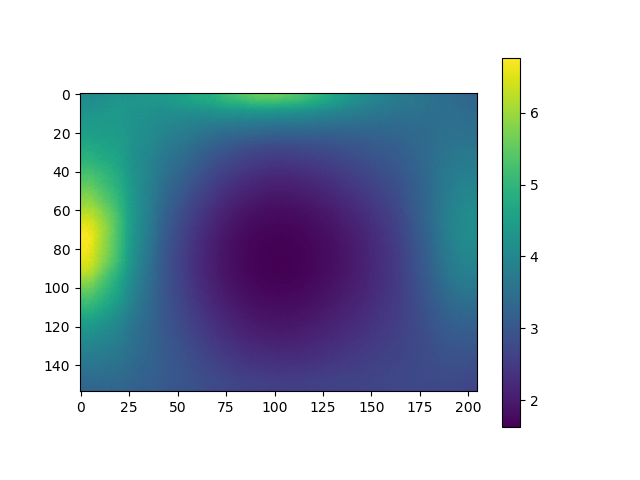

In [82]:
snr_image = np.mean(np.sqrt(np.sum(smoothed_compensation**2, axis=-1))/norm_white, axis=-1)

plt.figure()
plt.imshow(snr_image)
plt.colorbar()

It's worth noting that images from a nominally perfect camera, with a standard Bayer filter on it, still have some not insignificant amount of crosstalk between the colours.  If we use the centre of the camera as a reference, perhaps this is a more reasonable aim (i.e. the crosstalk is not reduced to zero, just to the value that it has in the centre).  We can achieve this by multiplying the correction matrix by a second matrix, such that the output that would have given the values recorded in the centre of the camera.

This has the (possibly obvious) effect that the brightness of the images acquired under R, G, and B illumination will be lower than that acquired under white light - that might seem undesirable, but I think it's also inevitable.

Previously (talking about one pixel, for clarity) we modelled the system as:
$$ v_i = M_{ij} c_j$$
where $v_i$ is the value recorded by the sensor, and $c_i$ is the colour of the illumination.  This suggests that an ideal camera would have $M$ diagonal, and so blue illumination would give $(0,0,255)$.  However, in reality the LED spectra will overlap with multiple colour channels, and even if they were laser lines there would be some bleed-through on the Bayer filter.  Thus, if we only want to undo the *extra* crosstalk that is due to the CRA compensation, we don't want to correct the camera with the matrix $C=M^{-1}$ because that will lead to an over-saturated image.

However, if we simply multiply $C$ with another matrix, $B$, which has the three colour values of the brightest (usually central) pixel under red, green, and blue illumination, this will give us a matrix that transforms to the colours we see in the region of the camera where CRA compensation doesn't cause a problem, for the single-colour images.  We are effectively keeping saturation the same in the "good" part of the sensor rather than artificially increasing it - this should also be beneficial from a noise point of view.

Normalised to the white image, the three LEDs give light that is: [[ 1.          1.          1.        ]
 [ 0.79460004  0.1516965   0.04178468]
 [ 0.15060665  0.55115056  0.16863791]
 [ 0.08324388  0.32003981  0.81522179]]
Adding up the R/G/B images, we get: [ 1.02845057  1.02288687  1.02564438]
Re-normalising so that the channels all sum to 1.


<IPython.core.display.Javascript object>


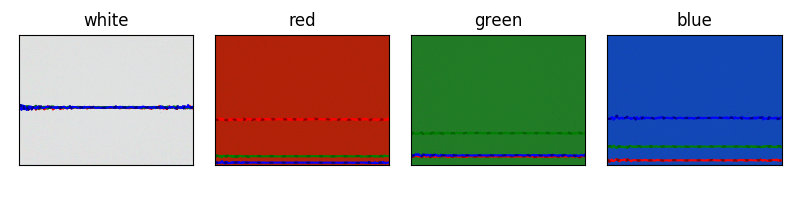

In [112]:
# First, start by determining the RGB values we should get for R/G/B illumination.
# This is easily done by taking the maximum values of the colour channels (the image is brightest in the centre)
def central_colour(image):
    # Find the colour of the central portion of an image
    w,h = image.shape[:2]
    return np.mean(np.mean(image[w*4//9:w//2+w*5//9, h*4//9:h*5//9, ...], axis=0), axis=0)

bright_colours = np.array([central_colour(img) for img in binned_images])
# Normalise to the white image (because it should be white)
bright_colours /= bright_colours[0,:]
print("Normalised to the white image, the three LEDs give light that is:", bright_colours)
# Get rid of the initial (white) image
bright_colours = bright_colours[1:,:] # This is the matrix $B$ - NB there is no factor of 255 in here
print("Adding up the R/G/B images, we get:", np.sum(bright_colours, axis=0))
bright_colours /= np.sum(bright_colours, axis=0) # Normalise so that the channels sum to 1,1,1 so white doesn't saturate
print("Re-normalising so that the channels all sum to 1.")

# Construct a new compensation matrix by multiplying the previous compensations by the bright_colours matrix
# This should still make the white image uniform and white, but now has the original saturations for R/G/B illumination
partial_compensation = np.sum(smoothed_compensation[:,:,:,np.newaxis,:]
                              *bright_colours[np.newaxis,np.newaxis,:,:,np.newaxis], 
                              axis=-3)

fig, ax = plt.subplots(1, 4, figsize=(8,2))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    output = np.sum(partial_compensation * image[:,:,np.newaxis,:], axis=-1)
    # This line was useful for debugging the colours in the bright_colours matrix
    #output = np.ones((100,100))[:,:,np.newaxis]*np.sum(bright_colours*np.array(rgb)[:,np.newaxis], axis=-2)[np.newaxis,np.newaxis,:]
    imshow_with_section(ax[i], output*0.9)
    
wrgb_col_titles(ax)
fig.tight_layout()

If we plot the matrix that we're using here, we expect to see that it has less of a noise penalty than the previous matrix:

<IPython.core.display.Javascript object>


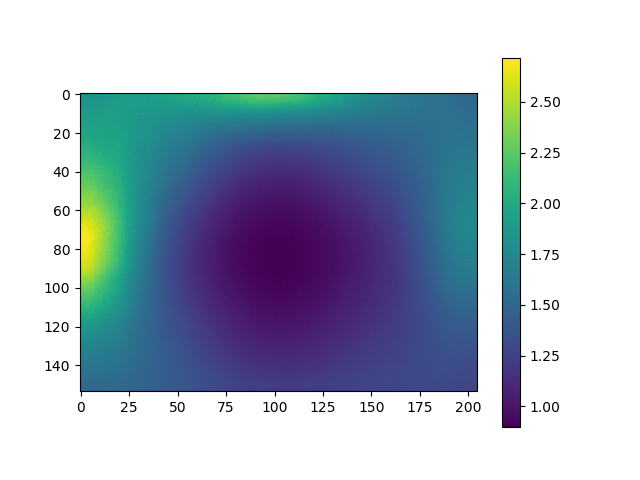

In [81]:
snr_image = np.mean(np.sqrt(np.sum(partial_compensation**2, axis=-1))/norm_white, axis=-1)

plt.figure()
plt.imshow(snr_image)
plt.colorbar()

As expected, there is more or less no SNR penalty in the centre of the image - because the centre of the image is unchanged.  The noise does increase by a factor of 2 or 3 towards the very edges of the image, but this is still less than half as bad as the oversaturated matrix.

<IPython.core.display.Javascript object>


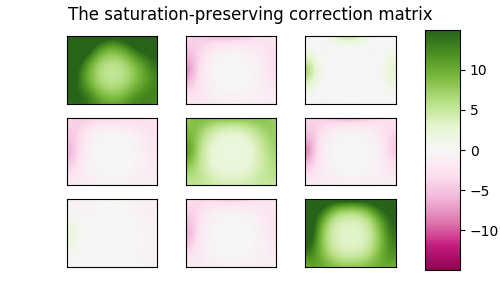

<IPython.core.display.Javascript object>


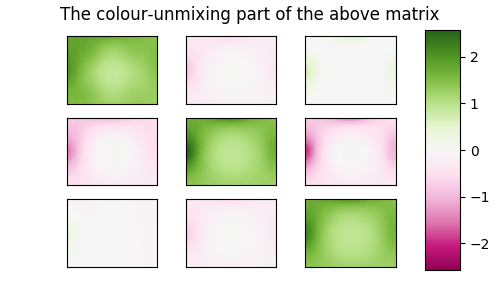

In [111]:
f, ax = plot_compensation_matrix(partial_compensation, clip_range=0.7)
f.suptitle("The saturation-preserving correction matrix")
unmixing_matrix = partial_compensation / norm_white[:,:,:,np.newaxis]
f, ax = plot_compensation_matrix(unmixing_matrix)
f.suptitle("The colour-unmixing part of the above matrix")

The two graphs above show the modified correction matrix - the point to take away is that the colour unmixing part of the matrix is much less extreme - this is the reason it doesn't oversaturate and also why the increase in noise on the image is not nearly so much.

## Summary
This notebook has outlined several methods - normalising using a single RGB image (equivalent to the "lens shading table" in the Pi Camera's GPU pipeline) and using two different matrices, one of which removes colour crosstalk and gives artificially saturated images, the other removes only the *additional* crosstalk due to the angle-dependent lenslet array on the sensor.  The third of these methods seems to strike a good compromise between providing uniform images, minimising noise, and faithfully reproducing colours across the whole sensor.  The figure below shows the results for each method.

<IPython.core.display.Javascript object>


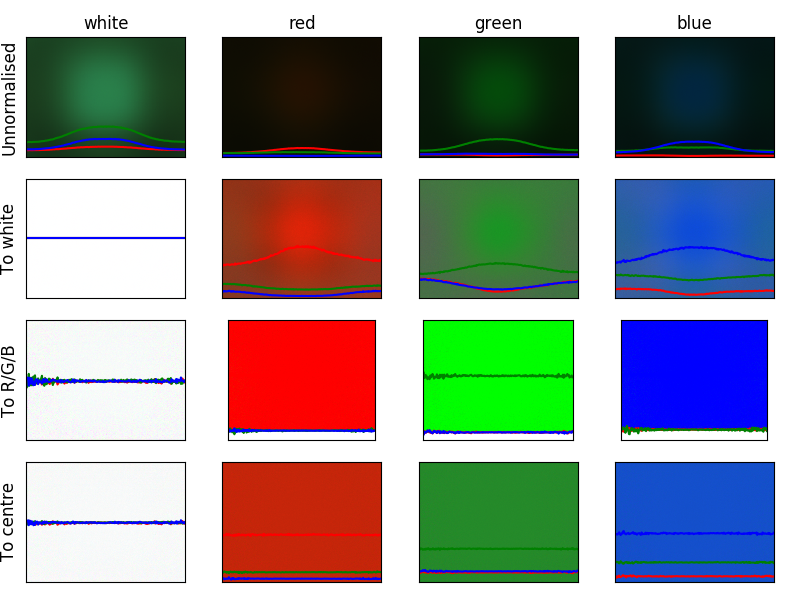

In [74]:
fig, ax = plt.subplots(4, 4, figsize=(8,6))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    imshow_with_section(ax[0,i], image)
    imshow_with_section(ax[1,i], image*norm_white)
    output = np.sum(smoothed_compensation * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[2,i], output)
    output = np.sum(partial_compensation * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[3,i], output)
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0],["Unnormalised","To white","To R/G/B","To centre"])
fig.tight_layout()